Path to dataset files: /root/.cache/kagglehub/datasets/tamilsel/healthcare-providers-data/versions/1
['Healthcare Providers.csv']
Found the dataset file: /root/.cache/kagglehub/datasets/tamilsel/healthcare-providers-data/versions/1/Healthcare Providers.csv
Available columns: ['index', 'National Provider Identifier', 'Last Name/Organization Name of the Provider', 'First Name of the Provider', 'Middle Initial of the Provider', 'Credentials of the Provider', 'Gender of the Provider', 'Entity Type of the Provider', 'Street Address 1 of the Provider', 'Street Address 2 of the Provider', 'City of the Provider', 'Zip Code of the Provider', 'State Code of the Provider', 'Country Code of the Provider', 'Provider Type', 'Medicare Participation Indicator', 'Place of Service', 'HCPCS Code', 'HCPCS Description', 'HCPCS Drug Indicator', 'Number of Services', 'Number of Medicare Beneficiaries', 'Number of Distinct Medicare Beneficiary/Per Day Services', 'Average Medicare Allowed Amount', 'Average Sub

<ipython-input-11-82f93d153e0e>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[existing_numerical_cols] = scaler.fit_transform(df[existing_numerical_cols])


Epoch 1/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7368 - val_loss: 0.5668
Epoch 2/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5564 - val_loss: 0.5630
Epoch 3/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5595 - val_loss: 0.5623
Epoch 4/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5561 - val_loss: 0.5619
Epoch 5/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5573 - val_loss: 0.5618
Epoch 6/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5545 - val_loss: 0.5618
Epoch 7/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5540 - val_loss: 0.5617
Epoch 8/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5531 - val_loss: 0.5615
Epoch 9/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5543 - val_loss: 0.5610
Epoch 10/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5541 - val_loss: 0.5609
Epoch 11/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5527 - val_loss: 0.5608
Epoch 12/50
2267/2267 ━━━━━

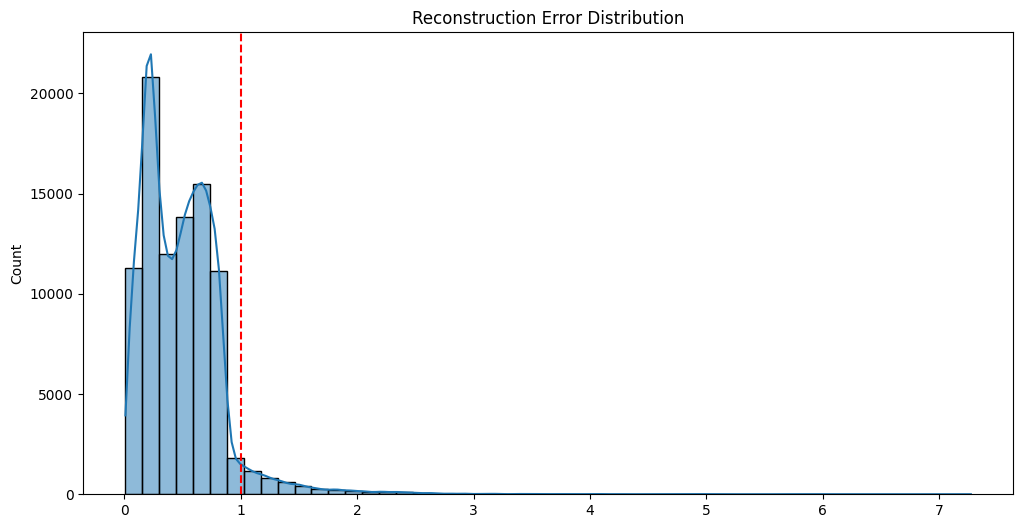

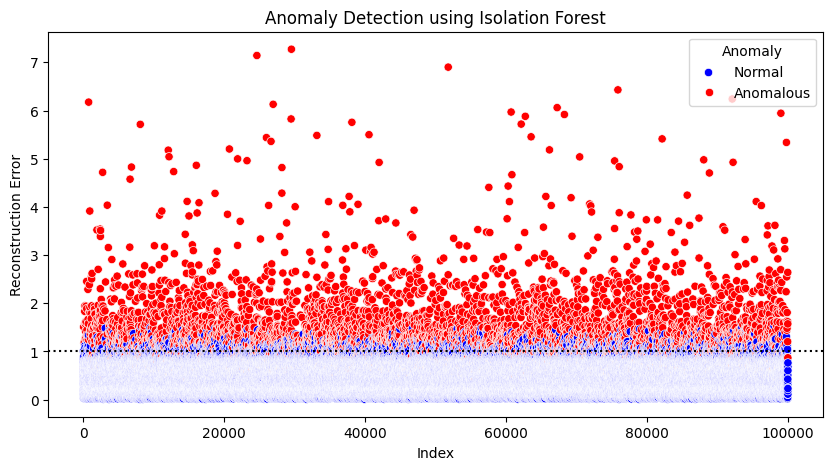

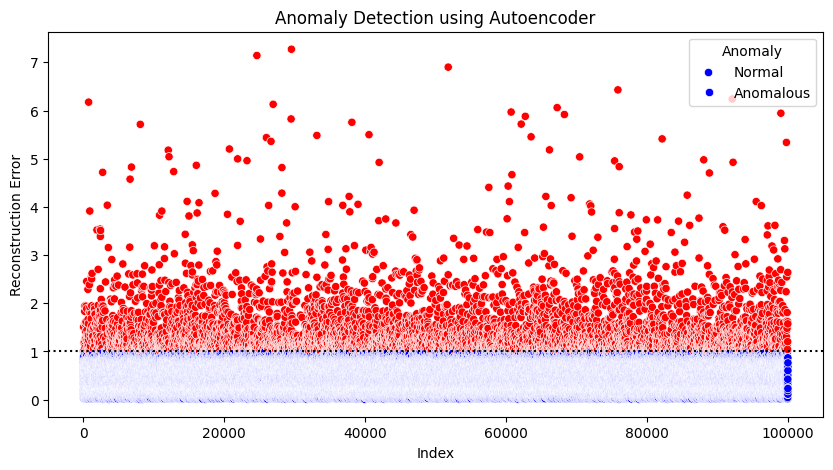

Anomalies Detected by Isolation Forest:
         index  National Provider Identifier  \
22     5156402                    1528061959   
36      571795                    1053584482   
99     9296367                    1942278858   
103     194487                    1013995406   
134    3196128                    1326075789   
...        ...                           ...   
99961  6736762                    1689649527   
99968  7924627                    1801835111   
99976   130745                    1013191105   
99980  1509836                    1154383610   
99989  1744264                    1174749816   

      Last Name/Organization Name of the Provider First Name of the Provider  \
22                                          AHUJA                       AMIT   
36                  EMPIRE CITY LABORATORIES, INC                        NaN   
99                                       KALENDEK                   MICHELLE   
103                                       BHAVSAR              

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import kagglehub
import os

# Download latest dataset version
path = kagglehub.dataset_download("tamilsel/healthcare-providers-data")
print("Path to dataset files:", path)
print(os.listdir(path))

# Load dataset, handling potential file location issues:
df = None
try:
    df = pd.read_csv(f"{path}/archive/healthcare_providers_data.csv")  # Try 'archive' subdirectory
except FileNotFoundError:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):  # Look for CSV files
                try:
                    df = pd.read_csv(os.path.join(root, file))
                    print(f"Found the dataset file: {os.path.join(root, file)}")
                    break
                except pd.errors.ParserError:
                    pass
        if df is not None:
            break

if df is None:
    raise FileNotFoundError("Could not find a suitable CSV file in the downloaded dataset.")

# Display dataset information
print("Available columns:", df.columns.tolist())
print(df.info())
print(df.head())

# Convert necessary columns to numeric (coercing errors)
numerical_cols = [
    "Number of Services", "Number of Medicare Beneficiaries",
    "Average Medicare Allowed Amount", "Average Submitted Charge Amount",
    "Average Medicare Payment Amount", "Average Medicare Standardized Amount"
]

# Ensure columns exist before conversion
existing_numerical_cols = [col for col in numerical_cols if col in df.columns]

# Convert object columns to float
df[existing_numerical_cols] = df[existing_numerical_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in numerical columns
df = df.dropna(subset=existing_numerical_cols)

# Scale numerical data
scaler = StandardScaler()
df[existing_numerical_cols] = scaler.fit_transform(df[existing_numerical_cols])

# Apply Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df["Anomaly_IF"] = iso_forest.fit_predict(df[existing_numerical_cols])

# Train an Autoencoder for anomaly detection
X_train, X_test = train_test_split(df[existing_numerical_cols], test_size=0.2, random_state=42)
input_dim = X_train.shape[1]
encoding_dim = 6

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(12, activation="relu"),
    layers.Dense(encoding_dim, activation="relu"),
    layers.Dense(12, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")
])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

X_pred = autoencoder.predict(df[existing_numerical_cols])
reconstruction_error = np.mean(np.abs(X_pred - df[existing_numerical_cols]), axis=1)
threshold = np.percentile(reconstruction_error, 95)
df["Anomaly_AE"] = reconstruction_error > threshold

# Visualizing Results
plt.figure(figsize=(12,6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed')
plt.title("Reconstruction Error Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=df.index, y=reconstruction_error, hue=df["Anomaly_IF"], palette={1: 'blue', -1: 'red'})
plt.axhline(threshold, color='black', linestyle='dotted')
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.legend(title="Anomaly", labels=["Normal", "Anomalous"])
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=df.index, y=reconstruction_error, hue=df["Anomaly_AE"], palette={True: 'red', False: 'blue'})
plt.axhline(threshold, color='black', linestyle='dotted')
plt.title("Anomaly Detection using Autoencoder")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.legend(title="Anomaly", labels=["Normal", "Anomalous"])
plt.show()

# Print detected anomalies
print("Anomalies Detected by Isolation Forest:")
print(df[df["Anomaly_IF"] == -1])

print("\nAnomalies Detected by Autoencoder:")
print(df[df["Anomaly_AE"] == True])